In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

### A0: Define the Domain

In [45]:
# Define the coordinates for the polygon 定义多边形的坐标
x = [0, 0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1, 1, 0.5, 0.5, 0.4, 0.4, 0]
y = [1, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 1, 1, 0.2, 0.2, 1, 1]
print(len(x))
print(len(y))

23
23


#### A.1 Sample the Domain

In [46]:
sampling_mode = 'grid'

if sampling_mode == 'at_random':
    sample_points, signed_distances = sample_domain(x, y, method='random', n_samples=500)       # Random sampling
else:
    sample_points, signed_distances = sample_domain(x, y, method='grid', grid_size=(32, 32))    # Grid sampling 32, 32

print(sample_points.shape) # 32 * 32 = 1024

(1024, 2)


#### A.2 Sample the Boundary

In [47]:
# Sample the boundary
n_boundary_samples = 1000

# Calculate the cumulative distance along the polygon 计算沿多边形的累积距离
dist = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
dist = np.insert(dist, 0, 0) / dist[-1]

# Generate evenly spaced points along the total distance 沿总距离生成等距点
t = np.linspace(0, 1, n_boundary_samples, endpoint=False)

# Interpolate to find the boundary points 插值找到边界点
boundary_x = np.interp(t, dist, x) 
boundary_y = np.interp(t, dist, y)

In [48]:
# Prepare all data
boundary_points = np.column_stack((boundary_x, boundary_y))
boundary_sdf = np.zeros((n_boundary_samples, 1)) # 边界点位于多边形边界上，因此它们的有符号距离定义为 0

X = np.vstack((sample_points, boundary_points)) # 合并点集
sdf_vals = np.vstack((signed_distances.reshape(-1, 1), boundary_sdf)) # 合并有符号距离

#### A3. Visualize

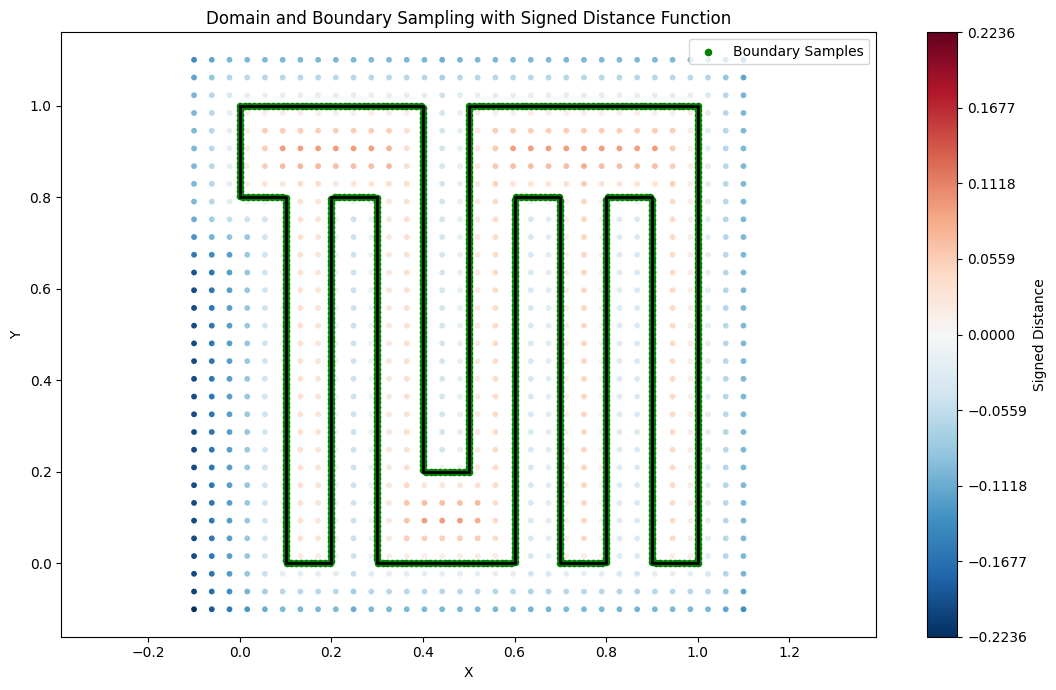

In [49]:
# Determine the maximum absolute value of the signed distances 确定有符号距离的最大绝对值
max_abs_distance = np.max(np.abs(signed_distances))

# Visualize
plt.figure(figsize=(11, 7))

# Use vmin and vmax to set symmetric limits for the colormap
# 使用有符号距离值作为点的颜色
scatter = plt.scatter(sample_points[:, 0], sample_points[:, 1], c=signed_distances, cmap='RdBu_r', s=10, 
                      vmin=-max_abs_distance, vmax=max_abs_distance) 

# Create a symmetric colorbar
cbar = plt.colorbar(scatter, label='Signed Distance')
cbar.set_ticks(np.linspace(-max_abs_distance, max_abs_distance, 9))

plt.plot(x, y, 'k-', linewidth=2) # 绘制多边形边界  黑色实线
plt.scatter(boundary_x, boundary_y, c='g', s=20, label='Boundary Samples')
plt.title('Domain and Boundary Sampling with Signed Distance Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

In [50]:
import torch
import torch.nn as nn

# Fourier feature mapping using PyTorch operations 傅里叶特征映射函数
def input_mapping(x, B): # B: 变换矩阵
    if B is None:
        return x
    else:
        x_proj = torch.matmul(x, B.t()) * (2.0 * np.pi) # B.t() 转置
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Custom layer for Fourier features
class FourierFeatures(nn.Module):
    def __init__(self, B=None):
        super(FourierFeatures, self).__init__()
        self.B = B  # B is a tensor or None

    def forward(self, inputs):
        return input_mapping(inputs, self.B)
    
# Create B_dict with different Fourier feature mappings 不同类型的映射矩阵
mapping_size = 256
B_dict = {
    'none': None,
    'basic': torch.eye(2, dtype=torch.float32),
    'gauss_1': torch.normal(mean=0, std=1.0, size=(mapping_size, 2), dtype=torch.float32),
    'gauss_10': torch.normal(mean=0, std=10.0, size=(mapping_size, 2), dtype=torch.float32),
    'gauss_100': torch.normal(mean=0, std=100.0, size=(mapping_size, 2), dtype=torch.float32),
}

B = B_dict['gauss_1']

# Define the MLP model with Fourier features
class NeuralSDF(nn.Module):
    def __init__(self, B=None):
        super(NeuralSDF, self).__init__()
        layers = []
        # Input layer: Fourier features
        self.fourier = FourierFeatures(B=B)

        # 6 hidden layers with 512 units and ReLU activation
        layers.append(nn.Linear(2*mapping_size, 512))
        layers.append(nn.ReLU())
        for _ in range(5):
            layers.append(nn.Linear(512, 512))
            layers.append(nn.ReLU())
        # Additional dense layers
        layers.append(nn.Linear(512, 32))
        layers.append(nn.Linear(32, 1))  # Output layer 输出 SDF 值
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.fourier(x) # 输入经过 FourierFeatures 层映射到高维特征
        return self.mlp(x)


# Convert input data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)   # 点集
sdf_vals = torch.tensor(sdf_vals, dtype=torch.float32)   # 有符号距离

# Define the neural network model
neural_SDF = NeuralSDF(B=B)

# Define loss function and optimizer
criterion = nn.L1Loss()  # 平均绝对误差（MAE）
optimizer = torch.optim.Adam(neural_SDF.parameters(), lr=1e-4)

# Define learning rate scheduler (equivalent to ReduceLROnPlateau)   监控验证损失，动态调整学习率
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # Minimize validation loss
    factor=0.5,          # 学习率减半
    patience=50,         # 50 个 epoch 无改进则降低学习率
    min_lr=1e-7          # 最小学习率
)

# Split data into training and validation sets 数据分割和加载
dataset = torch.utils.data.TensorDataset(X, sdf_vals)
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = len(dataset) - train_size  # 40% for validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_size//2, shuffle=True) # batch_size=int(len(dataset) * 0.8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_size)

# Training loop
neural_SDF.train()
num_epochs = 700
history = {'loss': [], 'val_loss': [], 'mse': [], 'val_mse': []}

for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    train_mse = 0.0
    for batch_X, batch_sdf in train_loader:
        optimizer.zero_grad()
        outputs = neural_SDF(batch_X)
        loss = criterion(outputs, batch_sdf)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
        train_mse += ((outputs - batch_sdf) ** 2).mean().item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    train_mse /= len(train_dataset)
    
    # Validation
    neural_SDF.eval()
    val_loss = 0.0
    val_mse = 0.0
    with torch.no_grad():
        for batch_X, batch_sdf in val_loader:
            outputs = neural_SDF(batch_X)
            val_loss += criterion(outputs, batch_sdf).item() * batch_X.size(0)
            val_mse += ((outputs - batch_sdf) ** 2).mean().item() * batch_X.size(0)
    val_loss /= len(val_dataset)
    val_mse /= len(val_dataset)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mse'].append(train_mse)
    history['val_mse'].append(val_mse)
    
    # Print progress (optional)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, '
              f'MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}')

#neural_SDF.eval()

Epoch [50/700], Loss: 0.006890, Val Loss: 0.007533, MSE: 0.000125, Val MSE: 0.000122
Epoch [100/700], Loss: 0.001950, Val Loss: 0.003151, MSE: 0.000007, Val MSE: 0.000019
Epoch [150/700], Loss: 0.002482, Val Loss: 0.003555, MSE: 0.000010, Val MSE: 0.000023
Epoch [200/700], Loss: 0.001443, Val Loss: 0.002092, MSE: 0.000003, Val MSE: 0.000011
Epoch [250/700], Loss: 0.000596, Val Loss: 0.001934, MSE: 0.000001, Val MSE: 0.000009
Epoch [300/700], Loss: 0.000848, Val Loss: 0.001752, MSE: 0.000001, Val MSE: 0.000008
Epoch [350/700], Loss: 0.000714, Val Loss: 0.001795, MSE: 0.000001, Val MSE: 0.000008
Epoch [400/700], Loss: 0.001089, Val Loss: 0.001750, MSE: 0.000002, Val MSE: 0.000008
Epoch [450/700], Loss: 0.000559, Val Loss: 0.001679, MSE: 0.000000, Val MSE: 0.000008
Epoch [500/700], Loss: 0.000147, Val Loss: 0.001492, MSE: 0.000000, Val MSE: 0.000007
Epoch [550/700], Loss: 0.000149, Val Loss: 0.001496, MSE: 0.000000, Val MSE: 0.000007
Epoch [600/700], Loss: 0.000182, Val Loss: 0.001466, MS

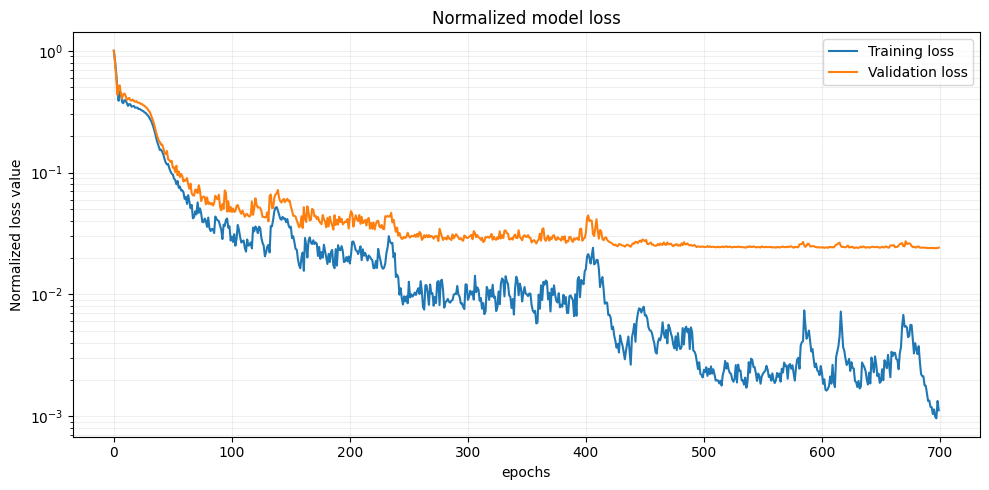

In [51]:
# 绘制训练历史
plt.figure(figsize=(10, 5))

# 归一化训练和验证损失
train_loss = np.array(history['loss'])
val_loss = np.array(history['val_loss'])

# 避免除以零，检查初始损失值
if train_loss[0] == 0 or val_loss[0] == 0:
    raise ValueError("初始损失值为 0, 无法进行归一化！")

plt.plot(train_loss / train_loss[0], label='Training loss')
plt.plot(val_loss / val_loss[0], label='Validation loss')

# 设置图表属性
plt.title('Normalized model loss')
plt.ylabel('Normalized loss value')
plt.xlabel('epochs')
plt.legend()
plt.yscale('log')  # 使用对数刻度
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()

# 保存图片
plt.savefig("Figures/SDF.png", dpi=300, bbox_inches='tight')
plt.show()

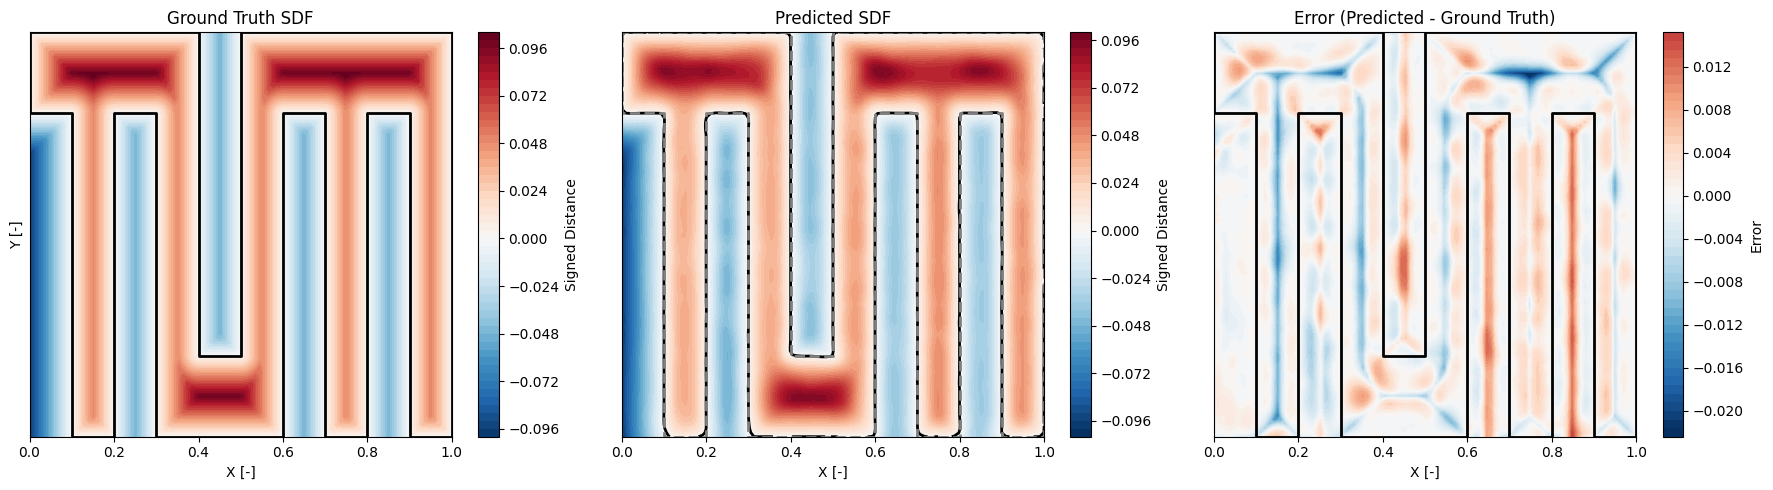

Mean Absolute Error: 0.002321
Max Absolute Error: 0.021821


In [52]:
# Convert x and y to numpy arrays if they're not already
x = np.array(x)
y = np.array(y)

# Generate a grid for visualization
x_grid, y_grid = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)
X_grid = np.column_stack((x_grid.ravel(), y_grid.ravel()))

# Predict SDF using the trained model
#predicted_sdf = neural_SDF.predict(X_grid).reshape(x_grid.shape)
# 将 X_grid 转换为 PyTorch 张量
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)

# 推理（预测 SDF 值）
with torch.no_grad():  # 禁用梯度计算以节省内存
    predicted_sdf_tensor = neural_SDF(X_grid_tensor)

# 转换为 NumPy 数组
predicted_sdf = predicted_sdf_tensor.cpu().numpy()  # 确保张量在 CPU 上

# 重塑为与 x_grid 相同的形状
predicted_sdf = predicted_sdf.reshape(x_grid.shape)

# Compute ground truth SDF for the grid
ground_truth_sdf = compute_signed_distance_vectorized(X_grid, x, y).reshape(x_grid.shape)

# Compute the error 直接相减误差
error_sdf = predicted_sdf - ground_truth_sdf 

# Determine the maximum absolute value of both SDFs and error for consistent color scaling
max_abs_sdf = max(np.max(np.abs(ground_truth_sdf)), np.max(np.abs(predicted_sdf)))
max_abs_error = np.max(np.abs(error_sdf))

# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Ground Truth SDF
contour1 = ax1.contourf(x_grid, y_grid, ground_truth_sdf, levels=50, cmap='RdBu_r', vmin=-max_abs_sdf, vmax=max_abs_sdf)
fig.colorbar(contour1, ax=ax1, label='Signed Distance')
ax1.plot(np.append(x, x[0]), np.append(y, y[0]), 'k-', linewidth=2)
ax1.set_title('Ground Truth SDF')
ax1.set_xlabel('X [-]')
ax1.set_ylabel('Y [-]')

# Predicted SDF
contour2 = ax2.contourf(x_grid, y_grid, predicted_sdf, levels=50, cmap='RdBu_r', vmin=-max_abs_sdf, vmax=max_abs_sdf)
fig.colorbar(contour2, ax=ax2, label='Signed Distance')
ax2.contour(x_grid, y_grid, predicted_sdf, levels=[0], colors='black', linewidths=2)  # Zero set contour
ax2.plot(np.append(x, x[0]), np.append(y, y[0]), color='grey', linestyle='--', linewidth=2)
ax2.set_title('Predicted SDF')
ax2.set_xlabel('X [-]')

# Error Plot
contour3 = ax3.contourf(x_grid, y_grid, error_sdf, levels=50, cmap='RdBu_r', vmin=-max_abs_error, vmax=max_abs_error)
fig.colorbar(contour3, ax=ax3, label='Error')
ax3.plot(np.append(x, x[0]), np.append(y, y[0]), 'k-', linewidth=2)
ax3.set_title('Error (Predicted - Ground Truth)')
ax3.set_xlabel('X [-]')
ax3.set_yticks([])  # Remove Y-axis ticks from ax3

plt.tight_layout()
plt.savefig("Figures/NN_SDF_with_Error.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some error statistics
mean_absolute_error = np.mean(np.abs(error_sdf))
max_absolute_error = np.max(np.abs(error_sdf))
print(f"Mean Absolute Error: {mean_absolute_error:.6f}")
print(f"Max Absolute Error: {max_absolute_error:.6f}")


In [53]:
# Save the entire model as a SavedModel
#neural_SDF.save('models\my_sdf_model')
import os
save_dir = 'models'
save_path = os.path.join(save_dir, 'my_sdf_model.pth')
torch.save(neural_SDF.state_dict(), save_path)